<a href="https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/ja/1-Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-OpenJij 入門

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/ja/1-Introduction.ipynb)

OpenJijは Isingモデル, QUBOのヒューリステック最適化ライブラリです。  
最適化のコア部分はC++で実装されていますが、Pythonインターフェースを備えているため、Pythonで簡単に書くことができます。

インストールにはpipを使用します。ただし、numpy を事前にインストールしておいてください。

In [1]:
# !pip install openjij

In [2]:
# 以下のコマンドでOpenJijの情報を見ることができます。実行環境によって出力は異なります。
!pip show openjij

Name: openjij
Version: 0.0.11
Summary: Framework for the Ising model and QUBO
Home-page: https://openjij.github.io/OpenJij/
Author: Jij Inc.
Author-email: openjij@j-ij.com
License: Apache License 2.0
Location: /Users/shonakamura/.pyenv/versions/3.6.9/lib/python3.6/site-packages
Requires: numpy, dimod, requests
Required-by: 


### Ising model

Ising model は統計物理学で扱われるモデルで、以下のように書かれます。

$$H(\{\sigma_i\}) = \sum_{i > j} J_{ij}\sigma_i \sigma_j + \sum_{i=1}^N h_i \sigma_i$$
$$\sigma_i \in \{-1, 1\}, i=1,\cdots N$$

ここで$H(\{\sigma_i\})$はハミルトニアンと呼ばれます。エネルギーやコスト関数だと考えてください。  
$\sigma_i$は2値$(1, -1)$を取る変数です。  

> $\sigma_i$は物理ではスピンという物理量に対応するため、スピン変数もしくは単純にスピンと呼ばれることもあります。  
> スピンとは小さな磁石のようなものです。-1 が磁石が上向き、1が下向きのように変数の値と物理(磁石の向き)が対応します。


$H$は変数の組み合わせ$\{\sigma_i\} = \{\sigma_1, \sigma_2, \cdots, \sigma_N\}$に依存します。  
$J_{ij}, h_i$が与えられる問題を表しています。それぞれ相互作用係数、縦磁場と呼ばれます。

OpenJijは$J_{ij} と h_i$が与えられたときに$H(\{\sigma_i\})$を最小化するスピン変数の組み$\{\sigma_i\}$を探してくれる数値計算ライブラリです。

具体的な例を一つ見ましょう。

## OpenJijに問題を投げてみる

変数の数が$N=5$で縦磁場と相互作用が

$$h_i = -1~\text{for} ~\forall i, ~ J_{ij} = -1~\text{for} ~\forall i, j$$

の問題を考えてみましょう。全ての相互作用がマイナスなので、各スピン変数は同じ値をとった方がエネルギーは低くなることがわかります。また縦磁場は全てマイナスなので、各スピンは1の値をとった方がエネルギーが低くなります。  
よってこの答えは $\{\sigma_i\} = \{1, 1, 1, 1, 1\}$になります。

ではこれを再現することをOpenJijを用いて計算しましょう。

In [3]:
import openjij as oj

# 問題を表す縦磁場と相互作用を作ります。OpenJijでは辞書型で問題を受け付けます。
N = 5
h = {i: -1 for i in range(N)}
J = {(i, j): -1 for i in range(N) for j in range(i+1, N)}

print('h_i: ', h)
print('Jij: ', J)

h_i:  {0: -1, 1: -1, 2: -1, 3: -1, 4: -1}
Jij:  {(0, 1): -1, (0, 2): -1, (0, 3): -1, (0, 4): -1, (1, 2): -1, (1, 3): -1, (1, 4): -1, (2, 3): -1, (2, 4): -1, (3, 4): -1}


In [4]:
# まず問題を解いてくれるSamplerのインスタンスを作ります。
# このインスタンスの選択で問題を解くアルゴリズムを選択できます。
sampler = oj.SASampler(num_reads=1)
# samplerのメソッドに問題(h, J)を投げて問題を解きます。
response = sampler.sample_ising(h, J)

# 計算した結果(状態)は response.states に入っています。
print(response.states)

# もしくは添字付きでみるには samples関数 を用います。
print([s for s in response.samples()])

[[1 1 1 1 1]]
[{0: 1, 1: 1, 2: 1, 3: 1, 4: 1}]


## OpenJijの解説

上述のコードの解説をします。  
OpenJijは現在インターフェースを2つ備えており、上記で使ったものはD-Wave Oceanと同じインターフェースになっています。そのため、OpenJijで慣れておけばD-Wave Oceanへの変更がスムーズです。

> もう一つのインターフェースについてはここでは解説しませんが、OpenJijの仕組み`graph, method, algorithm`を直接使うことで拡張のしやすさを備えています。ここでは上のセルで扱ったインターフェースを使えるようになれば十分でしょう。

### Sampler

先ほどは問題を辞書型で作ったあとに、Samplerのインスタンスを作りました。
```python
sampler = oj.SASampler(num_reads=1)
```
ここでこのSamplerというのがどのようなアルゴリズム、マシンを使うかを選択しています。他のアルゴリズムを試したい時はこのSamplerを変更します。また`num_reads`引数に整数を入れることで、一度に解く回数(iteration回数)を指定することができます(詳細は後述)。

> OpenJijで扱っているアルゴリズムはヒューリスティックな確率アルゴリズムです。問題を解くたびに返す解が違ったり、必ずしも最適解を得ることができません。
> よって複数回問題を解き、その中でよい解を探すという手法をとります。そのため、ここでは解をサンプリングするという気持ちを込めてSamplerと呼んでいます。

> num_readsの値を明記しない場合、デフォルトのnum_reads=1で実行されます。

上のセルで用いた`SASampler`は`Simulated Annealing`というアルゴリズムを用いて、解をサンプリングしてくるSamplerです。  
他にも

- SQASampler : Simulated Quantum Annealing(SQA) という量子アニーリングを古典コンピュータでシミュレーションするアルゴリズム
- GPUSQASampler : SQAをGPUで実行するSamplerです。Chimeraグラフという特殊な構造のみが現状扱える

のSamplerが用意されています。

### sample_ising(h, J)
上述のとおり、問題を解く際は`.sample_ising(h, J)`のように縦磁場と相互作用を変数として代入して投入します。

後述しますた、Isingモデルと等価なQUBOの最適化を行う時は`.sample_qubo(Q)`を用います。

### Response

`.sample_ising(h, J)`はResponseクラスを返します。ResponseクラスにはSamplerが解いて出てきた解と各解のエネルギーが入っています。

- .states :
    - type : list(list(int))
    - num_reads回数の解が格納されている
    > 物理ではスピンの配列(解)を状態と呼ぶことがあります。.statesにはnum_reads回だけ解いた解が格納されているので複数の状態を格納しているという気持ちを込めて .states としています。
- .energies:
    - type : list(float)
    - num_reads回数分の各解のエネルギーが格納されている
- .indices:
    - type: list(object)
    - 解がlistでstatesに入っているが、それに対応する各スピンの添字を格納されている
- .first.sample:
    - type: dict
    - 最小エネルギー状態を取るときの状態が格納されている
- .first.energy:
    - type: float
    - 最小エネルギーの値

> ResponseクラスはD-WaveのdimodのSampleSetクラスを継承しています。より詳細な情報は以下のリンクに記述されています。  
> [dimodドキュメント、SampleSet](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampleset.html)

というパラメータが参照できます。実際にコードを見てみましょう。

In [5]:
# 実は h, J の添字を示す、辞書のkeyは数値以外も扱うことができます。
h = {'a': -1, 'b': -1}
J = {('a', 'b'): -1, ('b', 'c'): 1}
# num_reads 引数に値を代入することで、SAを10回試行する計算を一度の命令で解くことができます。
sampler = oj.SASampler(num_reads=10)  
response = sampler.sample_ising(h, J)
print(response.first.sample)
print(response.first.energy)

{'a': 1, 'b': 1, 'c': -1}
-4.0


In [6]:
# response.states を見てみましょう。10回分の解が入っていることがわかります。
print(response.states)

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]


> num_reads などコンストラクタで渡すパラメータは`.sample_ising`などのサンプリングを実行するメソッドで上書きすることができます。
> ```
> response = sampler.sample_ising(h, J, num_reads=2)
> response.states
> > [[1, 1, -1],[1, 1, -1]]
> ```

今回は問題が簡単なので、10回とも同じ答え [1,1,-1] になっていることがわかります。

In [7]:
# 次にエネルギーを見てみましょう。
response.energies

array([-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.])

エネルギーの値を10回とも同じ値を取っていることがわかります。  
`response.states`に入っている解はリストになっているため、問題をセットした時の `a, b, c`という文字列との対応がわかりません。それを調べるために`response.indices`を見てみましょう。

In [8]:
response.indices

['a', 'b', 'c']

最小のエネルギー値を持った状態のみが知りたい場合には `.first` が便利です。

In [9]:
response.first

Sample(sample={'a': 1, 'b': 1, 'c': -1}, energy=-4.0, num_occurrences=1)

## QUBOを解いてみる

社会の実問題を解きたい場合には、Ising modelよりも QUBO(Quadratic unconstraited binary optimization)として定式化した方が素直な場合が多いです。基本的には上述のIsing modelを使って解いた場合と同じです。

QUBOは以下のように書かれます。

$$H(\{q_i\}) = \sum_{i\geq j} Q_{ij}q_i q_j$$
$$q_i \in \{0, 1\}$$

Ising modelとの違いは、2値変数が0 と 1のバイナリ変数であることです。$\sum, Q_{ij}$の取り方には他にもやり方(例えば$Q_{ij}$を対称行列にするなど)がありますが、今回は上式のように定式化しておきましょう。

> Ising モデル と QUBO は相互変換が可能という意味で等価です。
> $q_i = (\sigma_i + 1)/2$という変換式を用いることで、変換が可能です。

QUBOでは$Q_{ij}$が与える問題で、$H(\{q_i\})$を最小化する0, 1の組み合わせ$\{q_i\}$を探しましょうという問題になります。ほぼIsing modelと一緒です。

また$q_i$はバイナリ変数なので、$q_i^2 = q_i$であることがわかります。よって上式を以下のように書き分けることができます。

$$H(\{q_i\}) = \sum_{i > j} Q_{ij}q_i q_j + \sum_i Q_{ii} q_i$$

$Q_{ij}$の添字が同じところは $q_i$の1次の項の係数に対応します。

これをOpenJijで解いてみましょう。

In [10]:
# Q_ij を辞書型でつくります。
Q = {(0, 0): -1, (0, 1): -1, (1, 2): 1, (2, 2): 1}
sampler = oj.SASampler()
# QUBOを解く時は .sample_qubo を使います。
response = sampler.sample_qubo(Q)
print(response.states)

[[1 1 0]]


QUBOでは変数が 0, 1のため、解も 0, 1で出力されていることがわかります。  
このようにOpenJij を用いて Ising modelとQUBOの最適化問題を解くことができます。

## 少し難しい問題を解いてみる

これまで解いてきた問題は簡単すぎたので、少し難しい問題を解いてみましょう。

今度は変数の数が50個でランダムに$Q_{ij}$が振られたQUBOを解いてみたいと思います。

In [11]:
N = 50
# ランダムにQij を作る
import random
Q = {(i, j): random.uniform(-1, 1) for i in range(N) for j in range(i+1, N)}

# OpenJijで解く
sampler = oj.SASampler()
response = sampler.sample_qubo(Q, num_reads=100)

In [12]:
# エネルギーを少しみてみます。
response.energies[:5]

array([-58.52024684, -58.00899992, -58.52024684, -58.52024684,
       -58.00899992])

エネルギーを見てみると、先ほどの例とは異なり違う値をとっていることがわかります。  
ランダムにQij を与えた場合、一般に問題は難しくなります。よってSASamplerも毎回同じ解を出しません。  
ではどのような解がでたのかを、エネルギーのヒストグラムで可視化してみましょう。

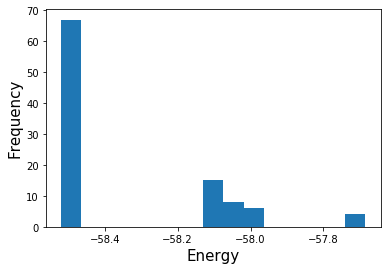

In [13]:
import matplotlib.pyplot as plt
plt.hist(response.energies, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが低いほど良い状態を算出したことになりますが、稀にエネルギーが高い状態も算出されていることが上のヒストグラムからわかります。しかし大半の計算結果はエネルギーが最低の状態を算出しています。
解いた(サンプルした)状態のうち一番低い解が最適解に近いはずなので、その解を.statesから探しましょう。
> 注意: SAは必ずしも最適解を導くものではありません。よってエネルギーが一番低い解を選んでも最適解であるという保証はありません。あくまで近似解です。

In [14]:
import numpy as np

min_samples = response.first
min_samples

Sample(sample={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 0, 9: 1, 10: 1, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0, 16: 1, 17: 1, 18: 0, 19: 0, 20: 0, 21: 1, 22: 1, 23: 1, 24: 1, 25: 0, 26: 0, 27: 0, 28: 1, 29: 0, 30: 1, 31: 1, 32: 1, 33: 0, 34: 1, 35: 1, 36: 0, 37: 1, 38: 1, 39: 1, 40: 1, 41: 0, 42: 1, 43: 0, 44: 1, 45: 1, 46: 0, 47: 0, 48: 1, 49: 1}, energy=-58.520246836411424, num_occurrences=1)

これでエネルギーが最も低い解を得ることができました。この`.first`に入っている状態が、今回得られた近似解です。これで「問題を近似的に解いた」ということになります。

`num_occurrences`は計算の結果その状態が何回出力されたかを表しています。

次回は "2-Evaluation" で Time to Solution や残留エネルギーなど、解をはかる指標について説明します。